# Imports

In [1]:
import pandas as pd
import numpy as np
np.random.seed(2121)

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import BayesianRidge
from sklearn.decomposition import PCA

In [2]:
batpos = pd.read_csv('../data/batpos_full_feature_extracted.csv')


In [3]:
# no longer need our player identifiers
batpos.drop(['name_common', 'player_id']
            , axis=1, inplace=True)

# Train-Test Split

As always, train-test split our data

In [4]:
target = 'waa_pg'

y = batpos[target]
X = batpos[[col for col in batpos.columns if col != target]]

X_train, X_test, y_train, y_test =\
    train_test_split(X, y,
                     test_size=0.2,
                     shuffle=True,
                     random_state = 1212)

After splitting, store X_test before standard scaling, etc. for baseline calculations in the modeling workbook.

In [5]:
X_test.to_csv('../data/X_test_full_for_baseline.csv')

# Standard Scale

Preprocess using standard scaling.

In [6]:
# initialize
ss = StandardScaler()

# fit on Train
X_train_ss = pd.DataFrame(ss.fit_transform(X_train),
                          columns = X_train.columns,
                          index = X_train.index)

# transform test
X_test_ss = pd.DataFrame(ss.transform(X_test),
                         columns = X_test.columns,
                         index = X_test.index)

# RFE

Right now we have 71 features in our dataset. Let's get that decreased to at least the best 20 using RFE.

In [7]:
rfecv = RFECV(
            estimator=BayesianRidge(),
            step = 1,
            cv = 5,
            scoring='r2',
            min_features_to_select=20)

rfecv.fit(X_train_ss,y_train)

cols_to_keep = X_train_ss.T[rfecv.ranking_==1].T.columns
cols_to_pc = X_train_ss.T[rfecv.ranking_!=1].T.columns

print(f'# of Columns Kept: {len(cols_to_keep)}')
print(f'# of Columns Dropped: {len(cols_to_pc)}')

# of Columns Kept: 39
# of Columns Dropped: 32


**Note** Normally SelectKBest() would be used to get the *best* 20 features, but I wanted the best 20 plus any other features that can improve it beyond that. The default estimator for SelectKBest() is BayesianRidge(), so that was used for RFE.

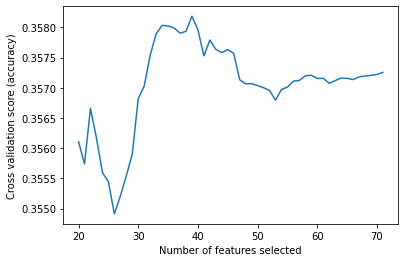

In [8]:
# https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(20, len(rfecv.cv_results_['mean_test_score'])+20),
    rfecv.cv_results_['mean_test_score']
)
plt.show()

**Observation** X=39 has the highest peak.

## Removed Features

During cleaning and EDA, a lot of features were earmarked for expected dropping. Let's examine the features dropped through RFE.

In [9]:
for i in range(0,35,5):
    print(', '.join(cols_to_pc.sort_values()[i:i+5]))

g_1b_share_1yr, g_1yr, g_2b_share_1yr, g_2b_share_2yr, g_2b_share_3yr
g_3b_share_1yr, g_3b_share_2yr, g_3b_share_3yr, g_cf_share_2yr, g_dh_share_2yr
g_of_1yr, g_of_2yr, g_of_3yr, g_ss_share_1yr, g_ss_share_2yr
g_ss_share_3yr, inn_per_team_gp_3yr, inn_pg_3yr, opprpg_1yr, opprpg_3yr
pa_per_team_gp_1yr, pa_per_team_gp_3yr, pa_pg_2yr, percent_team_gp_1yr, percent_team_gp_2yr
percent_team_gp_3yr, runs_br_pg_2yr, runs_br_pg_3yr, runs_defense_pg_3yr, runs_dp_pg_1yr
runs_position_pg_3yr, team_gp_2yr


-  Expected `g_*yr` features to be dropped. Only `g_1yr` was dropped.
-  Expected `team_gp_*yr` features to be dropped. Only `team_gp_2yr` was dropped.
-  Expected `runs_position_pg_*yr` features to be dropped. Only `runs_position_pg_3yr` was dropped.
-  Expected `opprpg_*yr` features to be dropped. Only `opprpg_2yr` **was not** dropped.
-  Expected `percent_team_gp_*yr` features to be dropped. All were!
-  Expected `inn_pg_*yr` features to be dropped. Only `inn_pg_3yr` was dropped.


-  Expected *all* positional features to be dropped. All 2B, 3B, OF, and SS were dropped. Portions of 1B, CF, and DH were. Catcher was the highest positively correlated position to `waa_pg` so that makes some sense. CF only dropping one position was surprising.


-  Surprisingly, `runs_defense_pg_3yr` was dropped. That was a feature I would've expected to stay given it's relationship with `waa_pg`.

# PCA

32 features were dropped during RFE. Instead of losing the signal completely from those features, add some of it back using 5 PCA features!

In [10]:
pca = PCA().fit(X_train_ss[cols_to_pc])

cum_var_exp = np.cumsum(pca.explained_variance_ratio_) * 100

for i, l in enumerate(pca.explained_variance_[:5]):
    print('PC {}: {:.2f} --> {:.2f}% --> {:.2f}%'.format(i, l,
                                             l * 100 / sum(pca.explained_variance_),
                                             cum_var_exp[i]))

PC 0: 4.85 --> 15.16% --> 15.16%
PC 1: 3.95 --> 12.35% --> 27.51%
PC 2: 3.73 --> 11.64% --> 39.15%
PC 3: 3.16 --> 9.88% --> 49.03%
PC 4: 2.50 --> 7.81% --> 56.84%


56.84% of the variance from the removed features can be explained in 5 PCA features!

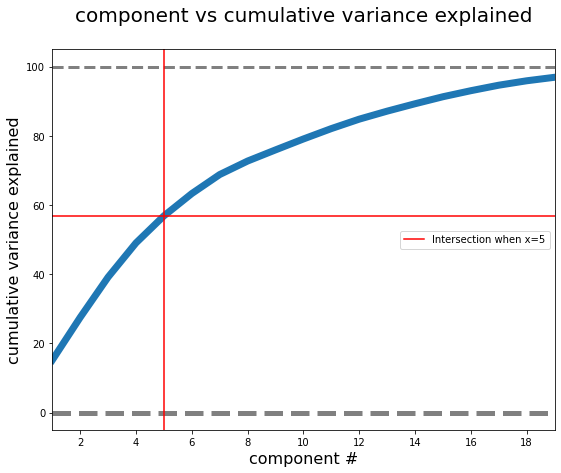

In [11]:
plt.figure(figsize=(9,7))
component_number = range(1, len(cols_to_pc)+1)
plt.plot(component_number, cum_var_exp, lw=7)
plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=100, linewidth=3, color='grey', ls='dashed')
ax = plt.gca()
ax.set_xlim([1,19])
ax.set_ylim([-5,105])
ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component #', fontsize=16)  
ax.set_title('component vs cumulative variance explained\n', fontsize=20)
ax.axhline(y=np.cumsum(pca.explained_variance_ratio_)[4]*100, c='r', label='Intersection when x=5')
ax.axvline(x=5,  c='r')
ax.legend();

In [12]:
# create dataframes for first 5 pca features
pca_df_train = pd.DataFrame(pca.transform(X_train_ss[cols_to_pc])[:,:5],
                     columns = ['pc_' + str(i) for i in range(5)],
                     index = X_train_ss.index)

pca_df_test = pd.DataFrame(pca.transform(X_test_ss[cols_to_pc])[:,:5],
                     columns = ['pc_' + str(i) for i in range(5)],
                     index = X_test_ss.index)

In [13]:
# update train and test to include pca
X_train_ss = pd.concat([X_train_ss[cols_to_keep], pca_df_train], axis=1)
X_test_ss = pd.concat([X_test_ss[cols_to_keep], pca_df_test], axis=1)

# Export

In [14]:
# consolidate test and train files
test = pd.merge(X_test_ss,y_test,left_index=True, right_index=True)
train = pd.merge(X_train_ss,y_train,left_index=True, right_index=True)

# add flag to train
train['is_train'] = 1

# concat train and test, fill is_train with 0 in test
batpos_preprocessed = pd.concat([test,train]).fillna(0)

In [15]:
batpos_preprocessed.to_csv('../data/batpos_full_preprocessed.csv')